# Load merchant embeddings and transactions embeddings and see if we have any matches

In [1]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec*

/opt/conda/lib/python3.10/site-packages/fsspec:
__init__.py  caching.py      core.py	    gui.py	     spec.py
__pycache__  callbacks.py    dircache.py    implementations  tests
_version.py  compression.py  exceptions.py  mapping.py	     transaction.py
archive.py   config.py	     fuse.py	    parquet.py	     utils.py
asyn.py      conftest.py     generic.py     registry.py

/opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info:
INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [3]:
%pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install fsspec==2023.6.0

Note: you may need to restart the kernel to use updated packages.


In [5]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec*

/opt/conda/lib/python3.10/site-packages/fsspec:
__init__.py  caching.py      core.py	    gui.py	     spec.py
__pycache__  callbacks.py    dircache.py    implementations  tests
_version.py  compression.py  exceptions.py  mapping.py	     transaction.py
archive.py   config.py	     fuse.py	    parquet.py	     utils.py
asyn.py      conftest.py     generic.py     registry.py

/opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info:
INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [6]:
#!mv /opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info/ mm/


In [7]:
!ls /opt/conda/lib/python3.10/site-packages/fsspec-2023.6.0.dist-info/

INSTALLER  METADATA  REQUESTED	direct_url.json
LICENSE    RECORD    WHEEL	top_level.txt


In [8]:
%pip install accelerate==0.27.2
%pip install sentence-transformers
%pip install --upgrade sentence_transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
#%pip install --force-reinstall --no-deps fsspec==2023.6.0


### Download model

In [ ]:
import boto3
import os

def download_s3_folder(bucket_name, s3_folder, local_path):
    """
    Download a folder (or "prefix") from S3 to the local filesystem.
    """
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')
    for result in paginator.paginate(Bucket=bucket_name, Prefix=s3_folder):
        if 'Contents' in result:
            for key in result['Contents']:
                # Extract file name from S3 key
                key_name = key['Key']
                local_file_path = os.path.join(local_path, os.path.basename(key_name))
                
                # Check if the key represents a folder
                if key_name.endswith('/'):
                    # Create local directory if it doesn't exist
                    os.makedirs(local_file_path, exist_ok=True)
                    # Recursively download folder contents
                    download_s3_folder(bucket_name, key_name, local_file_path)
                else:
                    # Create directory if it doesn't exist
                    os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
                    # Download file
                    try:
                        s3.download_file(bucket_name, key_name, local_file_path)
                    except NotADirectoryError as e:
                        print(f"Skipping file '{key_name}' due to error: {e}")

# Example usage
bucket_name = 'cleo-data-science'
base_name_path = 'model9/checkpoint-2000'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}"
local_path = f"/home/sagemaker-user/models/{base_name_path}"

download_s3_folder(bucket_name, s3_folder, local_path)

bucket_name = 'cleo-data-science'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}/1_Pooling"
local_path = f"/home/sagemaker-user/models/{base_name_path}/1_Pooling"


download_s3_folder(bucket_name, s3_folder, local_path)


In [10]:
!ls /home/sagemaker-user/models/

model1	model2	model3	model4	model9	model_download


In [11]:
imodel = 9

### Load test data

In [12]:
%pip install awswrangler
import awswrangler as wr

Note: you may need to restart the kernel to use updated packages.


In [13]:

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

### Load embeddings

In [16]:
s3_path_tx_embeddings = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
s3_path_tx_descriptions = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_merchant_trans_2024-05-22_2024-05-22.parquet"
# --- no merchant
s3_path_tx_embeddings ="s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/no_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
s3_path_tx_descriptions = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/no_merchant_trans_2024-05-22_2024-05-22.parquet"
# --- with duplicates
s3_path_tx_descriptions = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_duplicate_merchant_trans_2024-05-22_2024-05-22.parquet"
s3_path_tx_embeddings ="s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_duplicate_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
s3_path_duplicate_mapping = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/map_duplicates_cons_2024-05-15_2024-05-18_1.csv"

In [17]:
s3_path_merchant_embeddings = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/merchant_embeddings_cons_2024-05-15_2024-05-18_1.parquet"

In [18]:
df_tx_embeddings = wr.s3.read_parquet(path=s3_path_tx_embeddings)


In [35]:
df_descriptions = wr.s3.read_parquet(s3_path_tx_descriptions)
df_descriptions.head()

,transaction_id,merchant_name_combined,original_merchant_name_combined,description_combined_processed,amount,is_duplicate,len_description,distinct_transactions,avg_positive_amount,avg_negative_amount
0,9872916650,Family Dollar,Family Dollar,POS FAMILY DO 905 N 25TH A,-15.5,0,26,1561,80.113636,-18.602975
1,9888579858,Texas Roadhouse,Texas Roadhouse,PURCHASE TEXAS ROADHOUSE #,-10.8,0,27,111,79.600000,-58.146218
2,9945784365,Macdonald Book Shop,Macdonald Book Shop,VISA DDA PUR AP MACDONALD BOOKSHOP ESTES PARK ...,-29.3,0,50,1,0.000000,-29.300000
3,9872144869,Power Trac,Power Trac,POWER TRAC 10,-9.0,0,13,12,0.000000,-13.220000
4,9880088012,Brigit,Brigit,WITHDRAWAL ACH BRIGIT-COM TYPE: MEMBERSHIP ID:...,-10.0,0,115,8025,71.525000,-42.079375


In [19]:
df_tx_embeddings.head()

,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name
0,"[-0.4018181562423706, 0.4138648211956024, 0.35...",9872916650,POS FAMILY DO 905 N 25TH A,
1,"[0.6981315016746521, 0.8241245150566101, -0.20...",9888579858,PURCHASE TEXAS ROADHOUSE #,
2,"[-0.01953396573662758, 1.2296357154846191, 0.6...",9945784365,VISA DDA PUR AP MACDONALD BOOKSHOP ESTES PARK ...,
3,"[0.014985963702201843, -0.866848886013031, 0.8...",9872144869,POWER TRAC 10,
4,"[-0.38387832045555115, -0.009286105632781982, ...",9880088012,WITHDRAWAL ACH BRIGIT-COM TYPE: MEMBERSHIP ID:...,


In [20]:
df_merchant_embeddings =wr.s3.read_parquet(path=s3_path_merchant_embeddings)


In [21]:
df_tx_embeddings.shape

(500000, 4)

In [84]:
df_mapping_dups =wr.s3.read_csv(s3_path_duplicate_mapping)
df_mapping_dups


,Unnamed: 0,merchant_name_combined,original_merchant_name_combined
0,66140,Albert,W D
1,66351,Albert,Albert Cash
2,88797,Albert,Deferit
3,97317,Amazon,Point Of Sale Withdrawal
4,102313,Amazon,Withdrawal
...,...,...,...
14306,11199267,Samantha Rose Desi,Samantha Rose
14307,11199289,Webster County,County
14308,11199329,Howell''s Kitchen,Howell S Kitchen
14309,11199355,Jupiter Studio Limited Hong,Jupiter S


In [22]:
from sentence_transformers import SentenceTransformer, models
# from sentence_transformers import SentenceTransformer, InputExample
# from torch.utils.data import DataLoader
# from torch.utils.data import Dataset, DataLoader
# from sentence_transformers.losses import CoSENTLoss
# from datasets import Dataset
# from sentence_transformers.training_args import SentenceTransformerTrainingArguments
# from sentence_transformers.training_args import BatchSamplers
# from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
# from sentence_transformers import SentenceTransformerTrainer

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-06-11 06:50:17.244483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
embeddings_merchants = df_merchant_embeddings['original_merchant_name_combined_embedding'].tolist()

In [24]:
imodel = 9
istep = 5000
model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
model = SentenceTransformer(model_name)

In [25]:
import torch

In [26]:
list_unique_merchants = df_merchant_embeddings['original_merchant_name_combined'].tolist()


In [27]:
def do_predictions(model, df, batch_size_preds, embeddings_merchants, df_tx_embeddings):
    batch_size = batch_size_preds
    df['pred_merchant']=""
    df['pred_prob']=0.0
    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = df.loc[istart:iend-1,'description_combined_processed_embedding'].tolist()
            similarities = model.similarity(tx_embeddings, embeddings_merchants)
            print(similarities.shape)
            max_vals = torch.max(similarities, axis=1)
            max_probs = max_vals[0]
            ix_max_merchants = max_vals[1]
            predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
            df.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
            df.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)
    return df

In [28]:
batch_size_preds = 5000
df_tx_embeddings = do_predictions(model, df_tx_embeddings, batch_size_preds, embeddings_merchants, df_tx_embeddings)

0 5000


/opt/conda/lib/python3.10/site-packages/sentence_transformers/util.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/torch/csrc/utils/tensor_new.cpp:245.)
  a = torch.tensor(a)


torch.Size([5000, 86094])
5000 10000
torch.Size([5000, 86094])
10000 15000
torch.Size([5000, 86094])
15000 20000
torch.Size([5000, 86094])
20000 25000
torch.Size([5000, 86094])
25000 30000
torch.Size([5000, 86094])
30000 35000
torch.Size([5000, 86094])
35000 40000
torch.Size([5000, 86094])
40000 45000
torch.Size([5000, 86094])
45000 50000
torch.Size([5000, 86094])
50000 55000
torch.Size([5000, 86094])
55000 60000
torch.Size([5000, 86094])
60000 65000
torch.Size([5000, 86094])
65000 70000
torch.Size([5000, 86094])
70000 75000
torch.Size([5000, 86094])
75000 80000
torch.Size([5000, 86094])
80000 85000
torch.Size([5000, 86094])
85000 90000
torch.Size([5000, 86094])
90000 95000
torch.Size([5000, 86094])
95000 100000
torch.Size([5000, 86094])
100000 105000
torch.Size([5000, 86094])
105000 110000
torch.Size([5000, 86094])
110000 115000
torch.Size([5000, 86094])
115000 120000
torch.Size([5000, 86094])
120000 125000
torch.Size([5000, 86094])
125000 130000
torch.Size([5000, 86094])
130000 13500

In [30]:
#write predictions to file 
base_name = '/'.join(s3_path_tx_embeddings.split('/')[:-1])
s3_path_out =  f"{base_name}/predictions_{s3_path_tx_embeddings.split('/')[-1]}"
wr.s3.to_parquet(
        df=df_tx_embeddings,
        path=s3_path_out,
        dataset=True #,partition_cols=["merchant_name_combined"]
    )

print(f"Finsihed writing file {s3_path_out}")

Finsihed writing file s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/predictions_with_duplicate_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet


In [1]:
%pip install awswrangler
import awswrangler as wr

Note: you may need to restart the kernel to use updated packages.


In [4]:
#s3_embeddings_out= "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/predictions_no_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
# df_tx_embeddings = wr.s3.read_parquet(s3_embeddings_out)

In [31]:
df_tx_embeddings.head()

,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob
0,"[-0.4018181562423706, 0.4138648211956024, 0.35...",9872916650,POS FAMILY DO 905 N 25TH A,,Family Do Southern Gar,0.854380
1,"[0.6981315016746521, 0.8241245150566101, -0.20...",9888579858,PURCHASE TEXAS ROADHOUSE #,,Texas Roadhouse,0.888093
2,"[-0.01953396573662758, 1.2296357154846191, 0.6...",9945784365,VISA DDA PUR AP MACDONALD BOOKSHOP ESTES PARK ...,,Mcneill Ty Hof,0.512062
3,"[0.014985963702201843, -0.866848886013031, 0.8...",9872144869,POWER TRAC 10,,Power Trac,0.953408
4,"[-0.38387832045555115, -0.009286105632781982, ...",9880088012,WITHDRAWAL ACH BRIGIT-COM TYPE: MEMBERSHIP ID:...,,Brigit,0.839621


<Axes: >

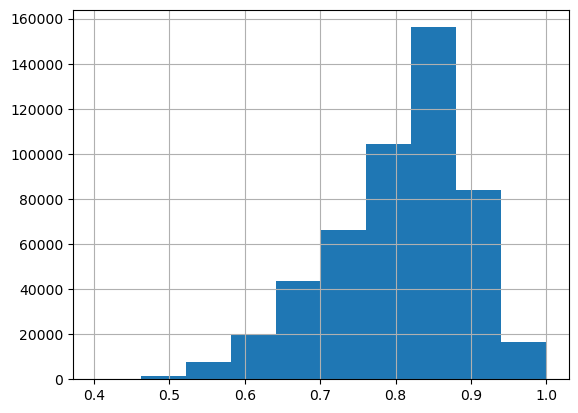

In [32]:
df_predictions = df_tx_embeddings.drop('description_combined_processed_embedding',axis=1)
df_predictions['pred_prob'].hist()

In [36]:
df_descriptions.head()

,transaction_id,merchant_name_combined,original_merchant_name_combined,description_combined_processed,amount,is_duplicate,len_description,distinct_transactions,avg_positive_amount,avg_negative_amount
0,9872916650,Family Dollar,Family Dollar,POS FAMILY DO 905 N 25TH A,-15.5,0,26,1561,80.113636,-18.602975
1,9888579858,Texas Roadhouse,Texas Roadhouse,PURCHASE TEXAS ROADHOUSE #,-10.8,0,27,111,79.600000,-58.146218
2,9945784365,Macdonald Book Shop,Macdonald Book Shop,VISA DDA PUR AP MACDONALD BOOKSHOP ESTES PARK ...,-29.3,0,50,1,0.000000,-29.300000
3,9872144869,Power Trac,Power Trac,POWER TRAC 10,-9.0,0,13,12,0.000000,-13.220000
4,9880088012,Brigit,Brigit,WITHDRAWAL ACH BRIGIT-COM TYPE: MEMBERSHIP ID:...,-10.0,0,115,8025,71.525000,-42.079375


In [38]:
df_all_preds = pd.merge(df_predictions, df_descriptions[['transaction_id','original_merchant_name_combined','merchant_name_combined']] , left_on = 'transaction_id', right_on = 'transaction_id')

In [39]:
df_all_preds.sort_values(by='pred_prob', ascending=False, inplace=True)
df_all_preds

,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob,original_merchant_name_combined,merchant_name_combined
571029,9880667674,PY HTEAO,,Py Hteao,1.000000,Py Hteao,Py Hteao
571028,9882895053,TIM HORTONS,,Tim Hortons,1.000000,Tim Hortons,Tim Hortons
571027,9881166298,Dd''s Discounts,,dd''s Discounts,1.000000,dd''s Discounts,DD''s Discounts
571013,9879380158,CUMBERLAND FARMS,,Cumberland Farms,1.000000,Cumberland Farms,Cumberland Farms
566323,9884570904,PrettyLitter,,Prettylitter,1.000000,Prettylitter,Prettylitter
...,...,...,...,...,...,...,...
4,9884791426,PURCHASE AUTHORIZED ON 05/21 MAINLINER CLUB OF...,,Reformation,0.417306,Mainliner Club,Mainliner Club
3,9890841901,PURCHASE AUTHORIZED ON 05/21 MAINLINER CLUB OF...,,Reformation,0.417306,Mainliner Club,Mainliner Club Of
2,9889732122,ZELLE FROM SEAN MARRIOTT ON 05/22 REF # COFUP8...,,Sean''s Convenience Sto,0.413870,Marriott,Marriott
1,9884393578,TRIPOLI''S LAWRENCE LAWRENCE MA 05/21,,Tassili''s Raw Rea,0.411047,Tripoli Pizza Salisbury,Tripoli Pizza Salisbury


In [48]:
df_predictions = df_all_preds

In [49]:
df_predictions.sort_values(by='pred_prob', ascending=True, inplace=True)
df_predictions_conf = df_all_preds[df_all_preds['pred_prob']>0.8]
df_predictions_conf.reset_index(drop=True, inplace=True)
df_predictions_conf

,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob,original_merchant_name_combined,merchant_name_combined
0,9883321136,POS Withdrawal / MERCARI888-325- MERCARI.COM CAUS,,Mercari,0.800000,Mercari,Mercari
1,9890347857,ATM WITHDRAWAL AUTHORIZED ON 05/22 512 W Stass...,,Atm,0.800001,Cash Withdrawal,Cash Withdrawal
2,9958732254,ATM WITHDRAWAL AUTHORIZED ON 05/22 512 W Stass...,,Atm,0.800001,Cash Withdrawal,Cash Withdrawal
3,9884926650,WEB INITIATED PAYMENT AT GASBUDDY GASBUDDY I5L...,,Gasbuddy,0.800002,Gasbuddy,Gasbuddy
4,10019667700,Withdrawal Debit Card Personal Debit CIRCLE K ...,,Circle S Gordon,0.800002,Circle K,Circle K
...,...,...,...,...,...,...,...
345272,9879203412,CUMBERLAND FARMS,,Cumberland Farms,1.000000,Cumberland Farms,Cumberland Farms
345273,9881139637,TOMS DRIVE THRU,,Toms Drive Thru,1.000000,Toms Drive Thru,Toms Drive Thru
345274,9881166298,Dd''s Discounts,,dd''s Discounts,1.000000,dd''s Discounts,DD''s Discounts
345275,9882895053,TIM HORTONS,,Tim Hortons,1.000000,Tim Hortons,Tim Hortons


In [20]:
df_predictions_conf['pred_merchant'].value_counts().to_frame()[0:50]

,count
pred_merchant,
Betfair,1551
Uber,1265
Draftkings,1166
McDonald''s,544
Apple Card,500
Lyft,467
FanDuel,382
Amazon,361
Apple,355


In [19]:

#write to csv file 
wr.s3.to_csv(
    df=df_predictions_conf,
    path="s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/csv_predictions_no_merchant_embeddings_trans_2024-05-22_2024-05-22.csv"
)

{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/csv_predictions_no_merchant_embeddings_trans_2024-05-22_2024-05-22.csv'],
 'partitions_values': {}}

In [6]:
#load embeddings
df_tx_embeddings = wr.s3.read_parquet(path=s3_embeddings_out)
df_tx_embeddings.shape

(1000000, 6)

In [50]:
list_unique_merchants = df_merchant_embeddings['original_merchant_name_combined'].tolist()


In [43]:
df_merchant_embeddings.head()

,original_merchant_name_combined,count,original_merchant_name_combined_embedding
0,Cash App,235691,"[-1.6722776889801025, 0.2621069848537445, -0.0..."
1,Savings,200907,"[-0.0667705088853836, 0.31939151883125305, -0...."
2,Dave Inc,156513,"[-0.8327934741973877, 0.7148804068565369, 0.21..."
3,Walmart,135952,"[0.7696321606636047, -0.8352966904640198, 0.56..."
4,Cash Withdrawal,133395,"[-0.7784464955329895, 0.1591707170009613, 0.08..."


In [47]:
df_tx_embeddings.head(2)

,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob
0,"[-0.4018181562423706, 0.4138648211956024, 0.35...",9872916650,POS FAMILY DO 905 N 25TH A,,Family Do Southern Gar,0.854380
1,"[0.6981315016746521, 0.8241245150566101, -0.20...",9888579858,PURCHASE TEXAS ROADHOUSE #,,Texas Roadhouse,0.888093


In [51]:
df_tx_embeddings.head()

,description_combined_processed_embedding,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob
0,"[-0.4018181562423706, 0.4138648211956024, 0.35...",9872916650,POS FAMILY DO 905 N 25TH A,,Family Do Southern Gar,0.854380
1,"[0.6981315016746521, 0.8241245150566101, -0.20...",9888579858,PURCHASE TEXAS ROADHOUSE #,,Texas Roadhouse,0.888093
2,"[-0.01953396573662758, 1.2296357154846191, 0.6...",9945784365,VISA DDA PUR AP MACDONALD BOOKSHOP ESTES PARK ...,,Mcneill Ty Hof,0.512062
3,"[0.014985963702201843, -0.866848886013031, 0.8...",9872144869,POWER TRAC 10,,Power Trac,0.953408
4,"[-0.38387832045555115, -0.009286105632781982, ...",9880088012,WITHDRAWAL ACH BRIGIT-COM TYPE: MEMBERSHIP ID:...,,Brigit,0.839621


In [52]:
df_tx_embeddings = df_all_preds

In [53]:
df_tx_embeddings.head()

,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob,original_merchant_name_combined,merchant_name_combined
0,9887365399,PURCHASE AUTHORIZED ON 05/21 SQ *ZODIAC CORPOR...,,Innovatus,0.402010,Zodiac Corporation,Zodiac Corporation
1,9884393578,TRIPOLI''S LAWRENCE LAWRENCE MA 05/21,,Tassili''s Raw Rea,0.411047,Tripoli Pizza Salisbury,Tripoli Pizza Salisbury
2,9889732122,ZELLE FROM SEAN MARRIOTT ON 05/22 REF # COFUP8...,,Sean''s Convenience Sto,0.413870,Marriott,Marriott
3,9890841901,PURCHASE AUTHORIZED ON 05/21 MAINLINER CLUB OF...,,Reformation,0.417306,Mainliner Club,Mainliner Club Of
4,9884791426,PURCHASE AUTHORIZED ON 05/21 MAINLINER CLUB OF...,,Reformation,0.417306,Mainliner Club,Mainliner Club


In [54]:
# How many of the test set merchants are in the original training dataset

print(df_tx_embeddings['original_merchant_name_combined'].nunique())
max_possible_matches = df_tx_embeddings[df_tx_embeddings['original_merchant_name_combined'].isin(list_unique_merchants)]
print(max_possible_matches['original_merchant_name_combined'].nunique())
n_max_possible_matches = max_possible_matches.shape[0]

71454
22094


In [107]:
mapping_dup_to_original = dict(zip(df_mapping_dups['merchant_name_combined'].tolist(), df_mapping_dups['original_merchant_name_combined'].tolist()))
mapping_dup_to_original
df_tx_embeddings['pred_merchant_mapped'] = df_tx_embeddings['pred_merchant'].map(mapping_dup_to_original).fillna(df_tx_embeddings['pred_merchant'])

In [171]:
df_mapping_dups[df_mapping_dups['original_merchant_name_combined']=='Cleo']

,Unnamed: 0,merchant_name_combined,original_merchant_name_combined
2242,1378149,Cash App,Cleo
2898,2085719,Zelle,Cleo
3157,2358700,Peacock,Cleo
3237,2443111,Cleo AI,Cleo
3435,2623223,Cleo Re,Cleo
3946,2796728,Cleo Ai,Cleo
6304,3720247,Grid,Cleo
6328,4010468,AfterPay,Cleo


In [165]:
df_tx_embeddings_mapped = pd.merge(df_tx_embeddings, df_mapping_dups,left_on='pred_merchant', right_on='merchant_name_combined', how='left')


,pred_merchant,original_merchant_name_combined_x,merchant_name_combined_x,pred_merchant_mapped,is_right
0,Innovatus,Zodiac Corporation,Zodiac Corporation,Innovatus,False
1,Tassili''s Raw Rea,Tripoli Pizza Salisbury,Tripoli Pizza Salisbury,Tassili''s Raw Rea,False
2,Sean''s Convenience Sto,Marriott,Marriott,Sean''s Convenience Sto,False
3,Reformation,Mainliner Club,Mainliner Club Of,Reformation,False
4,Reformation,Mainliner Club,Mainliner Club,Reformation,False
...,...,...,...,...,...
26313706,Cumberland Farms,Cumberland Farms,Cumberland Farms,Withdrawal,True
26313707,Toms Drive Thru,Toms Drive Thru,Toms Drive Thru,Toms Drive Thru,True
26313708,dd''s Discounts,dd''s Discounts,DD''s Discounts,dd''s Discounts,True
26313709,Tim Hortons,Tim Hortons,Tim Hortons,Tim Hortons,True


In [169]:
df_tx_embeddings_mapped[df_tx_embeddings_mapped['pred_merchant']=='Cleo Re'][['pred_merchant','original_merchant_name_combined_x','merchant_name_combined_x','pred_merchant_mapped','is_right']]

,pred_merchant,original_merchant_name_combined_x,merchant_name_combined_x,pred_merchant_mapped,is_right
282998,Cleo Re,Cleo,Cleo,Withdrawal Bill,False
282999,Cleo Re,Cleo,Cleo,Withdrawal Bill,False
283000,Cleo Re,Cleo,Cleo,Withdrawal Bill,False
283001,Cleo Re,Cleo,Cleo,Withdrawal Bill,False
283002,Cleo Re,Cleo,Cleo,Withdrawal Bill,False
...,...,...,...,...,...
26111351,Cleo Re,Cleo,Cleo,Withdrawal Bill,False
26111352,Cleo Re,Cleo,Cleo,Withdrawal Bill,False
26111353,Cleo Re,Cleo,Cleo,Withdrawal Bill,False
26114946,Cleo Re,Cleo,Cleo,Withdrawal Bill,False


In [167]:
df_tx_embeddings_mapped[['pred_merchant','original_merchant_name_combined_x','merchant_name_combined_x','pred_merchant_mapped','is_right']]

,pred_merchant,original_merchant_name_combined_x,merchant_name_combined_x,pred_merchant_mapped,is_right
0,Innovatus,Zodiac Corporation,Zodiac Corporation,Innovatus,False
1,Tassili''s Raw Rea,Tripoli Pizza Salisbury,Tripoli Pizza Salisbury,Tassili''s Raw Rea,False
2,Sean''s Convenience Sto,Marriott,Marriott,Sean''s Convenience Sto,False
3,Reformation,Mainliner Club,Mainliner Club Of,Reformation,False
4,Reformation,Mainliner Club,Mainliner Club,Reformation,False
...,...,...,...,...,...
26313706,Cumberland Farms,Cumberland Farms,Cumberland Farms,Withdrawal,True
26313707,Toms Drive Thru,Toms Drive Thru,Toms Drive Thru,Toms Drive Thru,True
26313708,dd''s Discounts,dd''s Discounts,DD''s Discounts,dd''s Discounts,True
26313709,Tim Hortons,Tim Hortons,Tim Hortons,Tim Hortons,True


In [125]:
df_tx_embeddings['is_right'] =( (df_tx_embeddings['pred_merchant_mapped'] == df_tx_embeddings['original_merchant_name_combined']) | (df_tx_embeddings['pred_merchant_mapped'] == df_tx_embeddings['merchant_name_combined'])) | \
( (df_tx_embeddings['pred_merchant'] == df_tx_embeddings['original_merchant_name_combined']) | (df_tx_embeddings['pred_merchant'] == df_tx_embeddings['merchant_name_combined']))

In [126]:
df_tx_embeddings

,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob,original_merchant_name_combined,merchant_name_combined,is_right,true_vs_pred,pred_merchant_mapped
0,9887365399,PURCHASE AUTHORIZED ON 05/21 SQ *ZODIAC CORPOR...,,Innovatus,0.402010,Zodiac Corporation,Zodiac Corporation,False,Zodiac Corporation :: Innovatus,Innovatus
1,9884393578,TRIPOLI''S LAWRENCE LAWRENCE MA 05/21,,Tassili''s Raw Rea,0.411047,Tripoli Pizza Salisbury,Tripoli Pizza Salisbury,False,Tripoli Pizza Salisbury :: Tassili''s Raw Rea,Tassili''s Raw Rea
2,9889732122,ZELLE FROM SEAN MARRIOTT ON 05/22 REF # COFUP8...,,Sean''s Convenience Sto,0.413870,Marriott,Marriott,False,Marriott :: Sean''s Convenience Sto,Sean''s Convenience Sto
3,9890841901,PURCHASE AUTHORIZED ON 05/21 MAINLINER CLUB OF...,,Reformation,0.417306,Mainliner Club,Mainliner Club Of,False,Mainliner Club :: Reformation,Reformation
4,9884791426,PURCHASE AUTHORIZED ON 05/21 MAINLINER CLUB OF...,,Reformation,0.417306,Mainliner Club,Mainliner Club,False,Mainliner Club :: Reformation,Reformation
...,...,...,...,...,...,...,...,...,...,...
571026,9879203412,CUMBERLAND FARMS,,Cumberland Farms,1.000000,Cumberland Farms,Cumberland Farms,True,Cumberland Farms :: Cumberland Farms,Withdrawal
571012,9881139637,TOMS DRIVE THRU,,Toms Drive Thru,1.000000,Toms Drive Thru,Toms Drive Thru,True,Toms Drive Thru :: Toms Drive Thru,Toms Drive Thru
571027,9881166298,Dd''s Discounts,,dd''s Discounts,1.000000,dd''s Discounts,DD''s Discounts,True,dd''s Discounts :: dd''s Discounts,dd''s Discounts
571028,9882895053,TIM HORTONS,,Tim Hortons,1.000000,Tim Hortons,Tim Hortons,True,Tim Hortons :: Tim Hortons,Tim Hortons


In [130]:
th = 0.8

df_filtered = df_tx_embeddings[df_tx_embeddings['pred_prob']>th]
true_positives = df_filtered[(df_filtered['pred_merchant_mapped'] == df_filtered['original_merchant_name_combined']) | (df_filtered['pred_merchant_mapped'] == df_filtered['merchant_name_combined']) |\
 (df_filtered['pred_merchant'] == df_filtered['original_merchant_name_combined']) | (df_filtered['pred_merchant'] == df_filtered['merchant_name_combined'])    ].shape[0]
false_positives = df_filtered[(df_filtered['pred_merchant_mapped'] != df_filtered['original_merchant_name_combined']) & (df_filtered['pred_merchant_mapped'] != df_filtered['merchant_name_combined']) &\
    (df_filtered['pred_merchant'] != df_filtered['original_merchant_name_combined']) & (df_filtered['pred_merchant'] != df_filtered['merchant_name_combined'])].shape[0]
precision = true_positives/(true_positives+false_positives)
#recall = true_positives/true_positives + false_negatives
max_possible_matches = df_filtered[df_filtered['original_merchant_name_combined'].isin(list_unique_merchants)].shape[0]
recall = true_positives/n_max_possible_matches
print(f"Precision {precision} Recall {recall}")

Precision 0.7665468594780422 Recall 0.5237970840680556


In [131]:
df_filtered[~df_filtered['is_right']]


,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob,original_merchant_name_combined,merchant_name_combined,is_right,true_vs_pred,pred_merchant_mapped
225754,9890347857,ATM WITHDRAWAL AUTHORIZED ON 05/22 512 W Stass...,,Atm,0.800001,Cash Withdrawal,Cash Withdrawal,False,Cash Withdrawal :: Atm,Atm
225755,9958732254,ATM WITHDRAWAL AUTHORIZED ON 05/22 512 W Stass...,,Atm,0.800001,Cash Withdrawal,Cash Withdrawal,False,Cash Withdrawal :: Atm,Atm
225757,10019667700,Withdrawal Debit Card Personal Debit CIRCLE K ...,,Circle S Gordon,0.800002,Circle K,Circle K,False,Circle K :: Circle S Gordon,Circle S Gordon
225760,9884594204,SOUTH COM SERVICES 05-21 SARASOTA FL DEBIT CAR...,,South,0.800002,South Com Services,South Com Services,False,South Com Services :: South,South
225762,9885001339,BREAKTIME VENDING BASKING RIDGE NJ 05/21,,Breaktime Vending Sou,0.800003,Break Time Vending,Break Time Vending,False,Break Time Vending :: Breaktime Vending Sou,Breaktime Vending Sou
...,...,...,...,...,...,...,...,...,...,...
568622,9873949865,Google Textnow,,Google Textnow,1.000000,Textnow,Textnow,False,Textnow :: Google Textnow,Google Textnow
568623,9873949865,Google Textnow,,Google Textnow,1.000000,Textnow,Textnow,False,Textnow :: Google Textnow,Google Textnow
570995,9891692537,NEXUS MODS EXETER,,Nexus Mods Exeter,1.000000,Nexusmods,Nexus Mods,False,Nexusmods :: Nexus Mods Exeter,Nexus Mods Exeter
571008,9878615293,Vet Canteen,,Vet Canteen,1.000000,Veterans Canteen,Veterans Canteen Service,False,Veterans Canteen :: Vet Canteen,Vet Canteen


In [132]:
df_tx_embeddings.head()

,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob,original_merchant_name_combined,merchant_name_combined,is_right,true_vs_pred,pred_merchant_mapped
0,9887365399,PURCHASE AUTHORIZED ON 05/21 SQ *ZODIAC CORPOR...,,Innovatus,0.402010,Zodiac Corporation,Zodiac Corporation,False,Zodiac Corporation :: Innovatus,Innovatus
1,9884393578,TRIPOLI''S LAWRENCE LAWRENCE MA 05/21,,Tassili''s Raw Rea,0.411047,Tripoli Pizza Salisbury,Tripoli Pizza Salisbury,False,Tripoli Pizza Salisbury :: Tassili''s Raw Rea,Tassili''s Raw Rea
2,9889732122,ZELLE FROM SEAN MARRIOTT ON 05/22 REF # COFUP8...,,Sean''s Convenience Sto,0.413870,Marriott,Marriott,False,Marriott :: Sean''s Convenience Sto,Sean''s Convenience Sto
3,9890841901,PURCHASE AUTHORIZED ON 05/21 MAINLINER CLUB OF...,,Reformation,0.417306,Mainliner Club,Mainliner Club Of,False,Mainliner Club :: Reformation,Reformation
4,9884791426,PURCHASE AUTHORIZED ON 05/21 MAINLINER CLUB OF...,,Reformation,0.417306,Mainliner Club,Mainliner Club,False,Mainliner Club :: Reformation,Reformation


In [133]:
df_tx_embeddings[~df_tx_embeddings['is_right']]

,transaction_id,description_combined_processed,merchant_name,pred_merchant,pred_prob,original_merchant_name_combined,merchant_name_combined,is_right,true_vs_pred,pred_merchant_mapped
0,9887365399,PURCHASE AUTHORIZED ON 05/21 SQ *ZODIAC CORPOR...,,Innovatus,0.402010,Zodiac Corporation,Zodiac Corporation,False,Zodiac Corporation :: Innovatus,Innovatus
1,9884393578,TRIPOLI''S LAWRENCE LAWRENCE MA 05/21,,Tassili''s Raw Rea,0.411047,Tripoli Pizza Salisbury,Tripoli Pizza Salisbury,False,Tripoli Pizza Salisbury :: Tassili''s Raw Rea,Tassili''s Raw Rea
2,9889732122,ZELLE FROM SEAN MARRIOTT ON 05/22 REF # COFUP8...,,Sean''s Convenience Sto,0.413870,Marriott,Marriott,False,Marriott :: Sean''s Convenience Sto,Sean''s Convenience Sto
3,9890841901,PURCHASE AUTHORIZED ON 05/21 MAINLINER CLUB OF...,,Reformation,0.417306,Mainliner Club,Mainliner Club Of,False,Mainliner Club :: Reformation,Reformation
4,9884791426,PURCHASE AUTHORIZED ON 05/21 MAINLINER CLUB OF...,,Reformation,0.417306,Mainliner Club,Mainliner Club,False,Mainliner Club :: Reformation,Reformation
...,...,...,...,...,...,...,...,...,...,...
568622,9873949865,Google Textnow,,Google Textnow,1.000000,Textnow,Textnow,False,Textnow :: Google Textnow,Google Textnow
568623,9873949865,Google Textnow,,Google Textnow,1.000000,Textnow,Textnow,False,Textnow :: Google Textnow,Google Textnow
570995,9891692537,NEXUS MODS EXETER,,Nexus Mods Exeter,1.000000,Nexusmods,Nexus Mods,False,Nexusmods :: Nexus Mods Exeter,Nexus Mods Exeter
571008,9878615293,Vet Canteen,,Vet Canteen,1.000000,Veterans Canteen,Veterans Canteen Service,False,Veterans Canteen :: Vet Canteen,Vet Canteen


In [134]:
df_tx_embeddings['original_merchant_name_combined']

0              Zodiac Corporation
1         Tripoli Pizza Salisbury
2                        Marriott
3                  Mainliner Club
4                  Mainliner Club
                   ...           
571026           Cumberland Farms
571012            Toms Drive Thru
571027            dd''s Discounts
571028                Tim Hortons
571029                   Py Hteao
Name: original_merchant_name_combined, Length: 571030, dtype: string

In [141]:
df_tx_embeddings['true_vs_pred'] = df_tx_embeddings['original_merchant_name_combined']+" :: "+df_tx_embeddings['pred_merchant_mapped']

In [142]:
df_right = df_tx_embeddings[df_tx_embeddings['is_right']]
df_wrong = df_tx_embeddings[~df_tx_embeddings['is_right']]

In [143]:
df_pairs_correct = df_right.groupby('true_vs_pred')['transaction_id'].agg('count').to_frame()
df_pairs_correct.reset_index(drop=False, inplace=True)
df_pairs_correct.rename(columns={'transaction_id':'num_transactions'}, inplace=True)
df_pairs_correct.sort_values(by='num_transactions', ascending=False, inplace=True)
df_pairs_correct

,true_vs_pred,num_transactions
5031,Earnin :: Pay Activ,21152
10462,McDonald''s :: Point Of Sale Withdrawal,11470
14408,Savings :: Savings,11378
728,Amazon :: Amazon Prime,10218
2250,Brigit :: Brigit,9876
...,...,...
8344,J Max :: J Max,1
8346,J P Lobby Shop :: J P Lobby Shop,1
8351,J&L Beverages :: J&L Beverages,1
8352,J's Food Market :: J's Food Market,1


In [144]:
df_pairs_incorrect = df_wrong.groupby('true_vs_pred')['transaction_id'].agg('count').to_frame()
df_pairs_incorrect.reset_index(drop=False, inplace=True)
df_pairs_incorrect.rename(columns={'transaction_id':'num_transactions'}, inplace=True)
df_pairs_incorrect.sort_values(by='num_transactions', ascending=False, inplace=True)
df_pairs_incorrect.reset_index(drop=True, inplace=True)
df_pairs_incorrect

,true_vs_pred,num_transactions
0,Walmart :: Wmt Plus,8671
1,Apple :: Apple Card,7265
2,Savings :: Savings Gas,4798
3,7 Eleven :: ExxonMobil,4457
4,Cash App :: Cash App.,4116
...,...,...
67939,Ginza :: Ginzacafe,1
67940,Ginza Bowl Pomona :: Ginzacafe,1
67941,Ginza Japanese Buffet :: Ginza Japane Charlesto,1
67942,Ginza Japanese Restaur :: Izumi Sushi & Asian ...,1


In [155]:
df_pairs_incorrect = df_wrong.groupby(['original_merchant_name_combined','pred_merchant']).agg(num_transactions=('transaction_id','count'), avg_prob=('pred_prob','mean'))
df_pairs_incorrect.sort_values(by='num_transactions', ascending=False, inplace=True)
df_pairs_incorrect.reset_index(drop=False, inplace=True)
df_pairs_incorrect_filtered = df_pairs_incorrect[(df_pairs_incorrect['num_transactions']>4) & (df_pairs_incorrect['avg_prob']>0.7)]
df_pairs_incorrect_filtered[0:20]

,original_merchant_name_combined,pred_merchant,num_transactions,avg_prob
0,Walmart,Walmart+,8667,0.807331
1,Apple,Apple Card,7265,0.852836
2,Savings,Savings Gas,4798,0.724124
3,7 Eleven,7-Eleven,4457,0.892418
4,Cash App,Cash App.,4116,0.725428
5,Albert,Albert Cash,3379,0.846961
6,Cleo,Cleo Re,2854,0.843508
7,Fan Duel Sportsbook,FanDuel,2359,0.871365
8,Online Banking Transfer,Savings Online Banking,2347,0.726732
9,Empower,Empower Advance,2251,0.896167


In [159]:
df_wrong_mapped = pd.merge(df_pairs_incorrect_filtered, df_mapping_dups,left_on='pred_merchant', right_on='merchant_name_combined', how='left')
df_wrong_mapped

,original_merchant_name_combined_x,pred_merchant,num_transactions,avg_prob,Unnamed: 0,merchant_name_combined,original_merchant_name_combined_y
0,Walmart,Walmart+,8667,0.807331,2569007.0,Walmart+,Walmart
1,Walmart,Walmart+,8667,0.807331,2569109.0,Walmart+,Overdraft Charge
2,Walmart,Walmart+,8667,0.807331,5369958.0,Walmart+,Wmt Plus
3,Apple,Apple Card,7265,0.852836,NaN,NaN,NaN
4,Savings,Savings Gas,4798,0.724124,NaN,NaN,NaN
...,...,...,...,...,...,...,...
12823,MoneyLion,Earnin,5,0.878776,502778.0,Earnin,Adjustment
12824,MoneyLion,Earnin,5,0.878776,526995.0,Earnin,POS Deposit
12825,MoneyLion,Earnin,5,0.878776,528458.0,Earnin,Point Of Sale Deposit
12826,MoneyLion,Earnin,5,0.878776,6151252.0,Earnin,Pay Activ


In [163]:
df_wrong2 = df_wrong_mapped[df_wrong_mapped['merchant_name_combined'].isnull()]
df_wrong2[df_wrong2['pred_merchant']=='Wmt Plus']

,original_merchant_name_combined_x,pred_merchant,num_transactions,avg_prob,Unnamed: 0,merchant_name_combined,original_merchant_name_combined_y


In [ ]:
df_wrong_mapped['']

In [154]:
df_mapping_dups[df_mapping_dups['merchant_name_combined']=='Cleo Re']

,Unnamed: 0,merchant_name_combined,original_merchant_name_combined
3435,2623223,Cleo Re,Cleo
6590,4623869,Cleo Re,Withdrawal Bill


In [153]:
df_mapping_dups[df_mapping_dups['original_merchant_name_combined']=='Withdrawal Bill']

,Unnamed: 0,merchant_name_combined,original_merchant_name_combined
6590,4623869,Cleo Re,Withdrawal Bill
7649,5126821,Affirm,Withdrawal Bill


In [145]:
df_pairs_incorrect = df_wrong.groupby('true_vs_pred').agg(num_transactions=('transaction_id','count'), avg_prob=('pred_prob','mean'))
df_pairs_incorrect.sort_values(by='num_transactions', ascending=False, inplace=True)
df_pairs_incorrect.reset_index(drop=False, inplace=True)
df_pairs_incorrect_filtered = df_pairs_incorrect[(df_pairs_incorrect['num_transactions']>4) & (df_pairs_incorrect['avg_prob']>0.7)]
df_pairs_incorrect_filtered[0:20]

,true_vs_pred,num_transactions,avg_prob
0,Walmart :: Wmt Plus,8671,0.807339
1,Apple :: Apple Card,7265,0.852836
2,Savings :: Savings Gas,4798,0.724124
3,7 Eleven :: ExxonMobil,4457,0.892418
4,Cash App :: Cash App.,4116,0.725428
5,Albert :: Albert Cash,3379,0.846961
6,Cleo :: Withdrawal Bill,2854,0.843508
7,Fan Duel Sportsbook :: FanDuel,2359,0.871365
8,Online Banking Transfer :: Savings Online Banking,2347,0.726732
9,Empower :: Empower Advance,2251,0.896167


In [148]:
df_mapping_dups

,Unnamed: 0,merchant_name_combined,original_merchant_name_combined
0,66140,Albert,W D
1,66351,Albert,Albert Cash
2,88797,Albert,Deferit
3,97317,Amazon,Point Of Sale Withdrawal
4,102313,Amazon,Withdrawal
...,...,...,...
14306,11199267,Samantha Rose Desi,Samantha Rose
14307,11199289,Webster County,County
14308,11199329,Howell''s Kitchen,Howell S Kitchen
14309,11199355,Jupiter Studio Limited Hong,Jupiter S


In [149]:
df_mapping_dups[df_mapping_dups['original_merchant_name_combined']=='Withdrawal Bill']

,Unnamed: 0,merchant_name_combined,original_merchant_name_combined
6590,4623869,Cleo Re,Withdrawal Bill
7649,5126821,Affirm,Withdrawal Bill


In [147]:
df_mapping_dups[df_mapping_dups['merchant_name_combined']=='Withdrawal Bill']

,Unnamed: 0,merchant_name_combined,original_merchant_name_combined


In [140]:
df_mapping_dups[df_mapping_dups['merchant_name_combined']=='Walmart+']

,Unnamed: 0,merchant_name_combined,original_merchant_name_combined
3361,2569007,Walmart+,Walmart
3362,2569109,Walmart+,Overdraft Charge
7746,5369958,Walmart+,Wmt Plus


In [122]:
wr.s3.to_csv(
    df=df_pairs_incorrect_filtered[df_pairs_incorrect_filtered['avg_prob']>0.8],
    path=incorrect_test_preds_csv,
)


NameError: name 'incorrect_test_preds_csv' is not defined

In [ ]:
df_pairs_incorrect

In [38]:
'Cleo AI' in  list_unique_merchants

True

In [ ]:
df_tx_embeddings['pred_merchant'].

# some predicted names like Cleo AI  don't exist, they are duplicates

In [37]:
df_pairs_incorrect[0:100]

,true_vs_pred,num_transactions
0,Apple :: Apple Card,23087
1,Walmart :: Walmart+,18395
2,Cleo :: Cleo AI,18020
3,Fan Duel Sportsbook :: FanDuel,11464
4,7 Eleven :: 7-Eleven,10778
...,...,...
95,In N Out Burger :: In-n-out Redding,354
96,Fan Duel Sportsbook :: Fspc,353
97,Hard Rock Bet :: Hard Rock Bet Appl,347
98,Dashpass :: Dashpa Www.doordash.,345


## Finished 

In [ ]:
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed/trans_2024-05-14_2024-05-14"
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"

# df_data_raw= wr.s3.read_parquet(path=s3_path)
# df_data_processed.shape

s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/raw/trans_2024-05-22_2024-05-22"
df_data_raw= wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

In [ ]:
keep_cols =['transaction_id','category_primary_plaid','merchant_name','original_description_plaid','description','amount']

In [ ]:
df_data_raw = df_data_raw[keep_cols]

In [ ]:
df_data_raw = df_data_raw[~df_data_raw['category_primary_plaid'].isin(['TRANSFER_OUT','TRANSFER_IN','LOAN_PAYMENTS','INCOME','BANK_FEES'])]
df_data_raw['len_description'] = df_data_raw['original_description_plaid'].apply(lambda x:len(x))
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].replace('None',None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].replace('',None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].replace(' ',None)
df_data_raw = df_data_raw.map(lambda x: None if pd.isna(x) else x)
pattern_transfer = r"(Cash\sApp\sTransfer\s[\w\s;]*)"
pattern_cash = r"(Cash\sApp)\s[\w\s;]*"
pattern_apple_cash_transfer = r"(Apple\sCash\sTransfer\s[\w\s;]*)"

df_data_raw['merchant_name'] = df_data_raw['merchant_name'].apply(lambda x: re.sub(pattern_transfer, r"Cash App Transfer", str(x)) if x != None  else None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].apply(lambda x: re.sub(pattern_cash, r"Cash App", str(x)) if x != None  else None)
df_data_raw['merchant_name'] = df_data_raw['merchant_name'].apply(lambda x: re.sub(pattern_apple_cash_transfer, r"Apple Cash", str(x)) if x != None  else None)



In [ ]:
df_data_raw['description_combined'] = df_data_raw['original_description_plaid'].combine_first(df_data_raw['description'])
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined'].apply(lambda x: re.sub('\\\\+','\\\\',x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(r'\d{4,}', ' ', x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(r'\d{4,}', ' ', x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(r'(.)\1{4,}', ' ', x))
df_data_raw['description_combined_processed'] =  df_data_raw['description_combined_processed'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
df_data_raw_no_merchant = df_data_raw[df_data_raw['merchant_name'].isnull()]
df_data_raw_with_merchant = df_data_raw[~df_data_raw['merchant_name'].isnull()]

In [ ]:
print(df_data_raw_no_merchant.shape[0])
print(df_data_raw_with_merchant.shape[0])

In [ ]:
df_data_raw_no_merchant = df_data_raw_no_merchant[df_data_raw_no_merchant['len_description'] >= 3]
df_data_raw_with_merchant = df_data_raw_with_merchant[df_data_raw_with_merchant['len_description'] >= 3]
print(df_data_raw_no_merchant.shape[0])
print(df_data_raw_with_merchant.shape[0])

In [ ]:
#sample to make faset
df_data_raw_with_merchant = df_data_raw_with_merchant.sample(1000000, random_state=1)

In [ ]:
df_data_raw_with_merchant['category_primary_plaid'].value_counts()

In [ ]:
df_data_raw_no_merchant['category_primary_plaid'].value_counts()

In [ ]:
df_data_raw_with_merchant.head(2)

In [ ]:
def positive_avg(series):
    return series.dropna()[series > 0].mean()
def negative_avg(series):
    return series.dropna()[series < 0].mean()

df_counts_tx = df_data_raw_with_merchant.groupby('merchant_name').agg(distinct_transactions =  ('transaction_id','nunique'),\
    avg_positive_amount = ('amount', positive_avg), avg_negative_amount =  ('amount', negative_avg))

In [ ]:
df_counts_tx.sort_values(by='distinct_transactions', ascending=False, inplace=True)
df_counts_tx = df_counts_tx.fillna(0)
df_counts_tx

In [ ]:
df_counts_tx[df_counts_tx['distinct_transactions']==1].shape

In [ ]:
try:
    del df_data_raw
except:
    pass

In [ ]:
df_data_raw_with_merchant = pd.merge(df_data_raw_with_merchant, df_counts_tx, left_on='merchant_name', right_on='merchant_name', how='left')

In [ ]:
df_data_raw_with_merchant.head()

# Load embedding model

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss
from datasets import Dataset
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

In [ ]:
imodel = 9
istep = 5000
model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
model = SentenceTransformer(model_name)

In [ ]:
import sentence_transformers
from sentence_transformers.evaluation import TripletEvaluator, BinaryClassificationEvaluator

In [ ]:
text_column =  "description_combined_processed"

In [ ]:
print(df_data_raw_with_merchant['merchant_name'].nunique())

In [ ]:
df_data_raw_with_merchant_cnt.head()

In [ ]:
import torch

In [ ]:
def get_tx_description_embeddings(model, df, text_column, batch_size_preds):
    batch_size = batch_size_preds
    all_embeddings = empty_array = np.empty((0, 768))

    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df[text_column][istart:iend].tolist())
            all_embeddings = np.concatenate((all_embeddings, tx_embeddings), axis=0)
            #df.loc[istart:iend-1,'tx_embedding'] =  tx_embeddings
    
    # Convert the numpy array into a list of arrays (or lists)
    embeddings_as_lists = [all_embeddings[i, :] for i in range(all_embeddings.shape[0])]

    # Create a DataFrame and assign the list of arrays to a single column
    df_embeddings = pd.DataFrame({text_column+'_embedding': embeddings_as_lists})
    df_embeddings['transaction_id'] = df['transaction_id']
    df_embeddings[text_column] = df[text_column]
    df_embeddings['merchant_name'] = ""
    try:
        df_embeddings['merchant_name'] = df['merchant_name']
    except:
        pass
    return df_embeddings    

In [ ]:
batch_size_preds = 5000
all_embeddings_1 = get_tx_description_embeddings(model, df_data_raw_with_merchant, text_column, batch_size_preds)

In [ ]:
#save embeddings in output file 
print(s3_path.split('/raw/')[1])

#s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/raw/trans_2024-05-22_2024-05-22"


In [ ]:
s3_path_out_embeddings = f"s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model{imodel}/checkpoint-{istep}/with_merchant_embeddings_{s3_path.split('/raw/')[1]}.parquet"
s3_path_out_data_with_merchant = f"s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model{imodel}/checkpoint-{istep}/with_merchant_{s3_path.split('/raw/')[1]}.parquet"
print(s3_path_out_embeddings)
print(s3_path_out_data_with_merchant)

In [ ]:
wr.s3.to_parquet(
        df=df_data_raw_with_merchant,
        path=s3_path_out_data_with_merchant,
        dataset=True #,partition_cols=["merchant_name_combined"]
    )

print(f"Finsihed writing file {s3_path_out_data_with_merchant}")


In [ ]:
wr.s3.to_parquet(
        df=all_embeddings_1,
        path=s3_path_out_embeddings,
        dataset=True #,partition_cols=["merchant_name_combined"]
    )

print(f"Finsihed writing file {s3_path_out_embeddings}")

In [ ]:
all_embeddings_1

# FINISH

In [ ]:
# load file to make sure everything is working
import awswrangler as wr
path_out = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-5000/with_merchant_embeddings_trans_2024-05-22_2024-05-22.parquet"
df_embeddings_load= wr.s3.read_parquet(path=path_out)
print(df_embeddings_load.shape)
df_embeddings_load.head()

In [ ]:

# Convert the numpy array into a list of arrays (or lists)
embeddings_as_lists = [all_embeddings_1[i, :] for i in range(all_embeddings_1.shape[0])]

# Create a DataFrame and assign the list of arrays to a single column
df_embeddings = pd.DataFrame({text_column+'_embedding': embeddings_as_lists})
df_embeddings

In [ ]:
def do_predictions(model, df, text_column, batch_size_preds, embeddings_merchants):
    batch_size = batch_size_preds
    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df[text_column][istart:iend].tolist())
            similarities = model.similarity(tx_embeddings, embeddings_merchants)
            print(similarities.shape)
            max_vals = torch.max(similarities, axis=1)
            max_probs = max_vals[0]
            ix_max_merchants = max_vals[1]
            predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
            df.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
            df.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)
    return df

In [ ]:
# From the test data, 
# Check how many get assigned to the right merchant
# precision and recall

In [ ]:
# From the test data
# See how many un

In [ ]:
df_data_raw_no_merchant.shape

In [ ]:
df_data_raw_no_merchant.head()

### Load model

In [ ]:
df_data_raw_no_merchant[df_data_raw_no_merchant['category_primary_plaid'] == 'GOVERNMENT_AND_NON_PROFIT']

In [ ]:
df_data_raw_no_merchant.head()

In [ ]:
df2['merchant_name'].isnull()

In [ ]:
df_data_raw_no_merchant.loc[7,'merchant_name']

In [ ]:
import pandas as pd

In [ ]:
df2 = df_data_raw_no_merchant.map(lambda x: None if pd.isna(x) else x)

In [ ]:

pattern_transfer = r"(Cash\sApp\sTransfer\s[\w\s;]*)"
pattern_cash = r"(Cash\sApp)\s[\w\s;]*"
pattern_apple_cash_transfer = r"(Apple\sCash\sTransfer\s[\w\s;]*)"

df2['merchant_name'] = df2['merchant_name'].apply(lambda x: re.sub(pattern_transfer, r"Cash App Transfer", str(x)) if x != None  else None)


In [ ]:
df2[df2['merchant_name'].isnull()]

In [ ]:
df2['merchant_name'] = df2['merchant_name'].apply(lambda x: re.sub(pattern_cash, r"Cash App", str(x)) if x != None  else None)
df2['merchant_name'] = df2['merchant_name'].apply(lambda x: re.sub(pattern_apple_cash_transfer, r"Apple Cash", str(x)) if x != None  else None)

In [ ]:
df2[df2['merchant_name'].isnull()].shape

In [ ]:
df_data_raw_no_merchant.loc[7,'merchant_name']

In [ ]:
df_data_raw_no_merchant = df_data_raw[df_data_raw['merchant_name'].isnull()]
df_data_raw_no_merchant.shape

In [ ]:
df_data_raw_no_merchant.reset_index(drop=True, inplace=True)
df_data_raw_no_merchant.shape

In [ ]:
df_data_raw.head()

In [ ]:
# df_data_processed[df_data_processed['true_merchant_name_combined'] == 'Cleo Re']

In [ ]:
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-14_2024-05-14_top_2001.parquet"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/ac45bd41a9274be39fe18728158c8beb.snappy.parquet"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"


df_data_raw = wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

In [ ]:
import pandas as pd

In [ ]:
import re
pattern = r"Cash\sApp\s(?!Transfer)[\w\s]+"
result = re.sub(pattern, "Cash App", 'Cash App Transfer')
result
df_data_raw['original_merchant_name_combined'] = df_data_raw['original_merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x) )
df_data_raw['true_merchant_name_combined'] = df_data_raw['true_merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x))
df_data_raw['merchant_name_combined'] = df_data_raw['merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x) )

In [ ]:
d1 = df_data_raw[df_data_raw['original_merchant_name_combined'] == 'Cash App'][:]
d2 = df_data_raw[df_data_raw['original_merchant_name_combined'] != 'Cash App'][:]
df_data_raw = pd.concat([d1.sample(50000, random_state = 1), d2], axis=0)
df_data_raw = df_data_raw.sample(3000000, random_state =1)

In [ ]:
df_ , df_test, y_, y_test = train_test_split(df_data_raw, df_data_raw['true_label'], test_size = 0.05, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_, df_['true_label'], test_size = 0.05, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_train.shape[0], df_test.shape[0], df_val.shape[0])

In [ ]:
df_train.head()

In [ ]:
df_test[df_test['original_merchant_name_combined'] == 'Cash App']

In [ ]:
df_merchants_counts = df_train['original_merchant_name_combined'].value_counts().to_frame()
df_merchants_counts.reset_index(drop=False, inplace=True)
top_merchants  = df_merchants_counts[0:2000]['original_merchant_name_combined'].to_list()
top_merchants

### First case when test set only has top merchants

In [ ]:
df_test_all = df_test.copy(deep=True)
df_test = df_test_all[df_test_all['original_merchant_name_combined'].isin(top_merchants)][:]
df_test.reset_index(drop=True, inplace=True)
df_test

In [ ]:
print(df_test['original_merchant_name_combined'].nunique())
print(df_test['true_merchant_name_combined'].nunique())
#print(df_test['merchant_name_combined'].nunique())

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss
from datasets import Dataset
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

In [ ]:
df_test.head()

In [ ]:
df_test.reset_index(drop=True, inplace=True)
ds_test = Dataset.from_pandas(df_test[['true_label','description_combined_processed','merchant_name_combined']])
ds_test = ds_test.rename_columns({"true_label": "score","description_combined_processed":"sentence1", "merchant_name_combined":"sentence2"})

In [ ]:
imodel = 9
istep = 2000
model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
model = SentenceTransformer(model_name)

In [ ]:
from sentence_transformers.evaluation import TripletEvaluator, BinaryClassificationEvaluator

In [ ]:
text_column =  "description_combined_processed"

In [ ]:
# dev_evaluator = EmbeddingSimilarityEvaluator(
#     sentences1=df_test[text_column],
#     sentences2=df_test["true_merchant_name_combined"],
#     scores=df_test["true_label"],
#     main_similarity=SimilarityFunction.COSINE,
#     name="sts-dev",
# )

In [ ]:
df_test['true_merchant_name_combined'].nunique()

In [ ]:
list_unique_merchants = df_train['original_merchant_name_combined'].unique()
print(f"Number of unique merchant {len(list_unique_merchants)}")
embeddings_merchants = model.encode(list_unique_merchants)
embeddings_merchants.shape

In [ ]:
import torch

In [ ]:
def do_predictions(model, df, text_column, batch_size_preds, embeddings_merchants):
    batch_size = batch_size_preds
    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df[text_column][istart:iend].tolist())
            similarities = model.similarity(tx_embeddings, embeddings_merchants)
            print(similarities.shape)
            max_vals = torch.max(similarities, axis=1)
            max_probs = max_vals[0]
            ix_max_merchants = max_vals[1]
            predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
            df.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
            df.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)
    return df

In [ ]:
# df_test = df_test[df_test['true_label']==1][:]
# df_test.reset_index(drop=True, inplace=True)

In [ ]:
df_test.shape

In [ ]:
print(df_test['true_merchant_name_combined'].nunique())
print(df_test['original_merchant_name_combined'].nunique())

In [ ]:
# df_test = do_predictions(model, df_test,text_column, 10000,embeddings_merchants)

In [ ]:
df_test.head()

In [ ]:
def get_prec_recall(df, th):

    df_filtered = df[df['pred_prob']>=th]
    n_filt = df_filtered.shape[0]
    true_positives = df_filtered[(df_filtered['true_merchant_name_combined'] == df_filtered['pred_merchant']) | (df_filtered['original_merchant_name_combined'] == df_filtered['pred_merchant']) ].shape[0]
    false_positives = df_filtered[(df_filtered['true_merchant_name_combined'] != df_filtered['pred_merchant']) & (df_filtered['original_merchant_name_combined'] != df_filtered['pred_merchant']) ].shape[0]

    # true_positives = df_filtered[df_filtered['true_merchant_name_combined'] == df_filtered['pred_merchant']].shape[0]
    # false_positives = df_filtered[df_filtered['true_merchant_name_combined'] != df_filtered['pred_merchant']].shape[0]
    #precision = tp /tp + fp
    if n_filt >= 1:
        precision = true_positives/n_filt
    else:
        precision = 0.0
    #recall = tp /tp + fn
    recall = true_positives/df.shape[0]
    return precision, recall


In [ ]:
batch_size_pred = 5000
imodel = 9

# Compare two different epochs

In [ ]:

def get_df_with_preds(df, imodel, istep, batch_size_pred):
    model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
    model = SentenceTransformer(model_name)
    df['pred_prob'] = 0.0
    df_['pred_merchant']=""
    df = do_predictions(model, df,text_column, batch_size_pred,embeddings_merchants)
    precision, recall = get_prec_recall(df, th)
    print(istep, precision, recall)
    return df, precision, recall 

In [ ]:
df_test.shape[0]

In [ ]:
print(df_test['true_merchant_name_combined'].nunique())
print(df_test['original_merchant_name_combined'].nunique())



In [ ]:
imodel = 9
df_small = df_test.sample(100000).reset_index(drop=True)

istep1 = 1600
batch_size_pred = 5000
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_small, imodel, istep1, batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 2000
df_test2, precision2, recall2 = get_df_with_preds(df_small, imodel, istep2, batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

In [ ]:
imodel = 9
df_small = df_test.sample(100000).reset_index(drop=True)

istep1 = 1400
batch_size_pred = 5000
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_small, imodel, istep1, batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 1600
df_test2, precision2, recall2 = get_df_with_preds(df_small, imodel, istep2, batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

In [ ]:
imodel = 7
istep1 = 800
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep1,batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 900
df_test2, precision2, recall2 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep2,batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

In [ ]:
prec_vec, recall_vec = [], []
th = 0.9

istep in range(100, 300, 400):
# istep_range =  [200,2000,2200]
for istep in istep_range:
   
   model_name = f"/home/sagemaker-user/models/model{imodel}-{istep}"
   model = SentenceTransformer(model_name)
   df_test['pred_prob'] = 0.0
   df_test['pred_merchant']=""
   df_test = do_predictions(model, df_test,text_column, batch_size_pred,embeddings_merchants)
   precision, recall = get_prec_recall(df_test, th)
   print(istep, precision, recall)
   prec_vec.append(precision)
   recall_vec.append(recall)
plt.plot(istep_range,prec_vec,'.-')
plt.plot(istep_range,recall_vec,'.-')

In [ ]:
#df_test1, precision1, recall1 = get_df_with_preds(df_test, imodel, 600, batch_size_pred)
#df_test2 has the lastest epoch

In [ ]:
df_test2.head(2)

### One epoch score distribution

In [ ]:
df_test.shape[0]

In [ ]:
#df_small = df_test.sample(100000).reset_index(drop=True)

In [ ]:
# one epoch

imodel = 9
istep1 = 2000
th = 0.75
df_test1, precision1, recall1 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep1,batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
plt.legend([istep1])

In [ ]:
#   original_merchant_name_combined is the real one ,
# merchant_name_cobined is the modified duplicate with coutnerprty 
# df_trans['original_merchant_name_combined'] = df_trans['merchant_name_combined']
# for duplicates , if counterparty_name != merchatn, then merchant_name_combined = counterparty_name
# merchant_name_combined : for duplicates, take

In [ ]:
print(precision1, recall1)

# Lets look at the duplicates only

In [ ]:
df_true_duplicates = df_test1[df_test1['is_duplicate']==1]
df_true_duplicates.reset_index(drop=True, inplace=True)
df_true_duplicates

In [ ]:
df_confident_duplicates = df_test1[(df_test1['pred_prob']>0.7) & (df_test['is_duplicate']==1)][['transaction_id','description_combined_processed','pred_merchant','true_merchant_name_combined','original_merchant_name_combined','pred_prob','is_duplicate']]
# ,'merchant_name_combined','true_label'
df_confident_duplicates

Basically , we want to know what percentage got deduplicated 

- pred_merchant == original_merchant_name_combined

And what percentage got mapped to the original merchant 

- pred_merchant == true_merchant_name_combined


And how many times it got mapped to something else





In [ ]:
#number of rows that got correctly mapped to the original merchant name
n_correct_duplicates_rows_detected_df = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['original_merchant_name_combined']]

n_correct_duplicates_rows_detected = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['original_merchant_name_combined']].shape[0]
n_correct_duplicates_rows_detected

In [ ]:
#number of rows that got correctly mapped to the duplicate name
n_correct_rows_mapped_df = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['true_merchant_name_combined']]

n_correct_rows_mapped = df_confident_duplicates[df_confident_duplicates['pred_merchant'] == df_confident_duplicates['true_merchant_name_combined']].shape[0]
n_correct_rows_mapped

In [ ]:
#numebr of rows that were not correctly mapped to either the original or duplicate name
n_incorrect_rows_df = df_confident_duplicates[(df_confident_duplicates['pred_merchant'] != df_confident_duplicates['true_merchant_name_combined']) &\
    (df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined'])]


n_incorrect_rows= df_confident_duplicates[(df_confident_duplicates['pred_merchant'] != df_confident_duplicates['true_merchant_name_combined']) &\
    (df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined'])].shape[0]
n_incorrect_rows

In [ ]:
n_incorrect_rows_df= df_confident_duplicates[(df_confident_duplicates['pred_merchant'] != df_confident_duplicates['true_merchant_name_combined']) &\
    (df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined'])]

n_incorrect_rows_df[0:30]

### Find the pairs of merchants that are beind considered as non-duplicate, duplicate

In [ ]:
n_correct_duplicate_pairs = n_correct_duplicates_rows_detected_df.drop_duplicates(subset=['pred_merchant','true_merchant_name_combined'])
n_correct_duplicate_pairs

In [ ]:
n_correct_nonduplicate_pairs = n_correct_rows_mapped_df.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
n_correct_nonduplicate_pairs

In [ ]:
n_incorrect_duplicate_pairs = n_incorrect_rows_df.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
n_incorrect_duplicate_pairs[0:30]

In [ ]:
n_true_duplicates = df_true_duplicates.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
n_true_duplicates

In [ ]:
df_true_duplicate_pairs = df_true_duplicates.drop_duplicates(subset=['pred_merchant','original_merchant_name_combined'])
df_true_duplicate_pairs

In [ ]:
#precison and recall of duplicate identification


# precision = tp /tp + fp

precision_detece_duplicates = n_correct_duplicate_pairs.shape[0]/(n_correct_duplicate_pairs.shape[0] + n_incorrect_duplicate_pairs.shape[0])
print(f"Precision of duplicate detection precision {precision_detece_duplicates}")


precision = (n_correct_duplicate_pairs.shape[0] + n_correct_nonduplicate_pairs.shape[0])/(n_correct_duplicate_pairs.shape[0] +n_correct_nonduplicate_pairs.shape[0]+ n_incorrect_duplicate_pairs.shape[0])
print(f"Precison of merchant detection {precision}")

# recall = tp/tp + fn

recall = n_correct_duplicate_pairs.shape[0]/df_true_duplicate_pairs.shape[0]
print(f"Recall of duplicate detection {recall}")



In [ ]:
df_confident_duplicates

# labels of merchant Names 

 - original_merchant_name_combined: the ground truth for the merchant name
 
 - If the row is not a duplicate, then original_merchant_name_combined = true_merchant_name_combined

 - If the row is a duplicate, then original_merchant_name_combined != true_merchant_name_combined, because the true_merchant_name is an artifical creation of a duplicate using coutnerparies type merchant. 


The column merchant name combined was created using the coutnerparties merchant name, when it was different to the Cleo name. So the names are different, we would hope that the we can identity that the combined name

In [ ]:
df_confident_duplicates[df_confident_duplicates['pred_merchant'] !=  df_confident_duplicates['merchant_name_combined']]

### Common confusions

In [ ]:
df_confident_duplicates['pred_vs_true'] = df_confident_duplicates['pred_merchant']+ ' ::  ' + df_confident_duplicates['original_merchant_name_combined']

In [ ]:
df_potential_duplicates = df_confident_duplicates[df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined']]['pred_vs_true'].value_counts().to_frame()
df_potential_duplicates.reset_index(drop=False, inplace=True)
df_potential_duplicates[0:30]

In [ ]:
df_potential_duplicates[df_potential_duplicates['count']>=3]

In [ ]:
# with a threshold of 0.8
# Looking at duplicates and a minimum of 3 transactions , 
true_positives_duplicates = df_potential_duplicates[df_potential_duplicates['count']>=2].shape[0]
true_positives_duplicates

In [ ]:
#false negatives
false_negatives_duplicates = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.7) ].shape[0]

In [ ]:
df_test1.head()

In [ ]:
 not_confident_duplicates = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.7) & (df_test1['pred_merchant']!= df_test['original_merchant_name_combined'])][['pred_prob','pred_merchant','original_merchant_name_combined']]
 not_confident_duplicates

In [ ]:
not_confident_duplicates['pred_vs_true'] = not_confident_duplicates['pred_merchant']+ ' ::  ' + not_confident_duplicates['original_merchant_name_combined']

In [ ]:
not_confident_duplicates['pred_vs_true'].value_counts()

In [ ]:
false_negatives_duplicates

In [ ]:
false_negatives_duplicates_data = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.75) ]
false_negatives_duplicates_data

In [ ]:
df_potential_duplicates[-30:]

In [ ]:
df_potential_duplicates

In [ ]:
df_confident_duplicates['pred_vs_true'].value_counts()

In [ ]:
df_confident_duplicates[df_confident_duplicates['pred_merchant'] !=  df_confident_duplicates['merchant_name_combined']]

In [ ]:
get_prec_recall(df_test1, th=0.8)

### How many of the duplicates did it find?

In [ ]:
all_duplicates = df_test2[df_test2['is_duplicate'] == 1][:]
all_duplicates[all_duplicates['pred_merchant']!= all_duplicates['true_merchant_name_combined']]

In [ ]:
#Let's look at the duplicates quality with the first epoch
some_cols = ['transaction_id','pred_prob','pred_merchant','true_merchant_name_combined','original_merchant_name_combined','description_combined_processed','is_duplicate']
df_potential_dups = df_test2[(df_test2['pred_prob']>0.8) & (df_test2['true_merchant_name_combined'] != df_test2['pred_merchant'])][some_cols]
df_potential_dups.reset_index(drop=True, inplace=True)
df_potential_dups

In [ ]:
df_test1[ (df_test1['is_duplicate']==1) & (df_test1['pred_prob']>0.8)][some_cols]

In [ ]:
df_test1['merchant_pairs'] = df_test1.apply(lambda x: x['true_merchant_name_combined']+ ' , ' + x['pred_merchant'], axis=1)

In [ ]:
#df_potential_dups['merchant_pairs'] = df_potential_dups['true_merchant_name_combined']
df_potential_dups['merchant_pairs'] = df_potential_dups.apply(lambda x: x['true_merchant_name_combined']+ ' , ' + x['pred_merchant'], axis=1)

In [ ]:
df_duplicate_cand_counts = df_potential_dups[['merchant_pairs']].value_counts().to_frame()
df_duplicate_cand_counts.reset_index(drop=False, inplace=True)
df_duplicate_cand_counts[0:30]

In [ ]:
df_data_processed[df_data_processed['transaction_id']==9790597722]

In [ ]:
df_data_raw[df_data_raw['transaction_id']==9790597722]

In [ ]:
df_train[df_train['true_merchant_name_combined']=='Cleo Re']

In [ ]:
df_test1[df_test1['merchant_pairs'] =='Cleo , Cleo Re']

In [ ]:
df_train[df_train['true_merchant_name_combined']=='Giant Food']['description_combined_processed'].tolist()

In [ ]:
df_train[df_train['true_merchant_name_combined']=='Giant']['description_combined_processed'].tolist()

In [ ]:
df_train[df_train['true_merchant_name_combined']=='Giant Food']

In [ ]:
# Example ('Giant', 'Giant Food', 'Giant Food Inc')
# On merchants table Giant Food Inc and Giant exist, they have the same twitter handle, should be deduplicated
# the 
# on transactions table
# 9798583952, Giant, merchant_id = 576243, entertainment, food aand drink, groceries
# 9788502083, merchant_name = None,  Counterparties: Giant Food, giantfood.com, transfer out, food aand drink, groceries

In [ ]:
df_test1[df_test1['merchant_pairs'] =='Giant , Giant Food']

In [ ]:
# get pairs that have the same m1, m2

In [ ]:
model = SentenceTransformer(model_name)
df_test['pred_prob'] = 0.0
df_test['pred_merchant']=""
df_test = do_predictions(model, df_test,text_column, batch_size_pred,embeddings_merchants)

In [ ]:
df_test

In [ ]:
precision, recall = get_prec_recall(df_test, th)
print(precision, recall)

In [ ]:
recall_vec

In [ ]:
batch_size = 5000
for istart in np.arange(0, df_test.shape[0]+1, batch_size):
    iend = min(df_test.shape[0],istart + batch_size)
    if iend> istart:
        print(istart, iend)
        tx_embeddings = model.encode(df_test['sentence'][istart:iend].tolist())
        similarities = model.similarity(tx_embeddings, embeddings_merchants)
        #print(similarities.shape)
        max_vals = torch.max(similarities, axis=1)
        max_probs = max_vals[0]
        ix_max_merchants = max_vals[1]
        predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
        df_test.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
        df_test.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)